In [8]:
#Librearìa que busca el servicio de spak
import findspark

#Librerìas para gestionar el servicio
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

#Iniciación de sesion
findspark.init()

#Creamos la conf de spak y seteamos un nombre para la aplicación
sparkConf = SparkConf().setAppName("Aplicacion de Creditos")
sc = SparkContext(conf=sparkConf)  #Creamos el contexto: Es como un string de conexion a unos contestos "x" y unas aplicaciones que estamos usando
spark = SparkSession(sc)

In [7]:
spark.stop() #Detiene la sesion de spark

In [9]:
# Cargar el set de datos
!wget https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/credit.csv

--2021-05-17 15:57:09--  https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/credit.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133638 (131K) [text/plain]
Saving to: 'credit.csv'

credit.csv          100%[===================>] 130.51K  --.-KB/s    in 0.07s   

2021-05-17 15:57:10 (1.86 MB/s) - 'credit.csv' saved [133638/133638]



In [10]:
!hdfs dfs -ls #Dentro de hadooop me muestre los archivos que tengo en el sistema de archivos de hadoop

In [11]:
#copiamos el archivo en el ssistema de archivos de hadoop
!hdfs dfs -copyFromLocal credit.csv /tmp/

In [12]:
#Validar si efectivamente se guardó el archivo en el sistema de archivos de hadoop
!hdfs dfs -ls /tmp/*csv

-rw-r--r--   1 root supergroup     133638 2021-05-17 19:29 /tmp/credit.csv


In [21]:
#Creamos el dataframe con el archivo .csv
creditos = spark.read.load('/tmp/credit.csv',
                           format="csv",
                           sep=',',
                           inferSchema='true',
                           header='true')

In [22]:
creditos.printSchema()

root
 |-- checking_balance: string (nullable = true)
 |-- months_loan_duration: integer (nullable = true)
 |-- credit_history: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- amount: integer (nullable = true)
 |-- savings_balance: string (nullable = true)
 |-- employment_length: string (nullable = true)
 |-- installment_rate: integer (nullable = true)
 |-- personal_status: string (nullable = true)
 |-- other_debtors: string (nullable = true)
 |-- residence_history: integer (nullable = true)
 |-- property: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- installment_plan: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- existing_credits: integer (nullable = true)
 |-- default: integer (nullable = true)
 |-- dependents: integer (nullable = true)
 |-- telephone: string (nullable = true)
 |-- foreign_worker: string (nullable = true)
 |-- job: string (nullable = true)



In [23]:
#Hacer un select a algunas columnas del dataframe. 
#En SQL server = select top 10 credit_history, purpose, amount from creditos
#en MySQL = select credit_history, purpose, amount from creditos limit 10
creditos.select(['credit_history', 'purpose', 'amount']).show(10)

+--------------+----------+------+
|credit_history|   purpose|amount|
+--------------+----------+------+
|      critical|  radio/tv|  1169|
|        repaid|  radio/tv|  5951|
|      critical| education|  2096|
|        repaid| furniture|  7882|
|       delayed| car (new)|  4870|
|        repaid| education|  9055|
|        repaid| furniture|  2835|
|        repaid|car (used)|  6948|
|        repaid|  radio/tv|  3059|
|      critical| car (new)|  5234|
+--------------+----------+------+
only showing top 10 rows



In [24]:
#Hacer un conteo
totalCreditos = creditos.count()
print('Total de créditos', totalCreditos)

Total de créditos 1000


In [25]:
#Hacer un filtro por registros
#En SQL = select months_loan_duration, credit_history, purpose, amount from creditos where months_loan_duration <= 24
filtro1 =  creditos.select(['months_loan_duration', 'credit_history', 'purpose', 'amount']).filter(creditos['months_loan_duration']<=24)
filtro1.show(10)

+--------------------+--------------+---------+------+
|months_loan_duration|credit_history|  purpose|amount|
+--------------------+--------------+---------+------+
|                   6|      critical| radio/tv|  1169|
|                  12|      critical|education|  2096|
|                  24|       delayed|car (new)|  4870|
|                  24|        repaid|furniture|  2835|
|                  12|        repaid| radio/tv|  3059|
|                  12|        repaid|car (new)|  1295|
|                  12|        repaid| radio/tv|  1567|
|                  24|      critical|car (new)|  1199|
|                  15|        repaid|car (new)|  1403|
|                  24|        repaid| radio/tv|  1282|
+--------------------+--------------+---------+------+
only showing top 10 rows



In [27]:
#Conteo de cuales crèditos son menor o igual a 24
catidadesfiltro1 = filtro1.count()
print('Cantidad de créditos menor o igual a 24 meses:', catidadesfiltro1)

Cantidad de créditos menor o igual a 24 meses: 770


In [30]:
#Funciones de agregacion: sumar, porcentaje, etc
#SQL = sleect purpose, sum(amount) as total from filtro1 group by purpose
from pyspark.sql import functions as F
filtro1.groupBy('purpose').agg(F.sum('amount')).show()

+-------------------+-----------+
|            purpose|sum(amount)|
+-------------------+-----------+
|           radio/tv|     411623|
|          education|      68765|
|          car (new)|     478796|
|             others|      36486|
|          furniture|     385044|
|domestic appliances|      10935|
|         retraining|      10853|
|           business|     143350|
|            repairs|      34439|
|         car (used)|     271660|
+-------------------+-----------+



In [48]:
#Promedios avg
filtro1.groupBy('purpose').agg(F.avg('amount')).show()

+-------------------+------------------+
|            purpose|       avg(amount)|
+-------------------+------------------+
|           radio/tv|1854.1576576576576|
|          education| 1910.138888888889|
|          car (new)|2406.0100502512564|
|             others| 5212.285714285715|
|          furniture|           2566.96|
|domestic appliances|            1093.5|
|         retraining| 1205.888888888889|
|           business|2559.8214285714284|
|            repairs|2025.8235294117646|
|         car (used)|         4244.6875|
+-------------------+------------------+



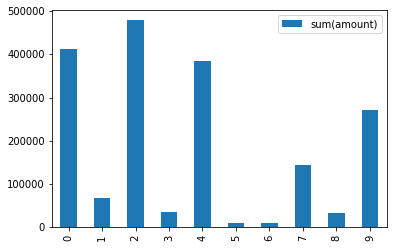

In [31]:
#Graficar los resultados
%matplotlib inline
filtro1.groupBy('purpose').agg(F.sum('amount')).toPandas().plot.bar()

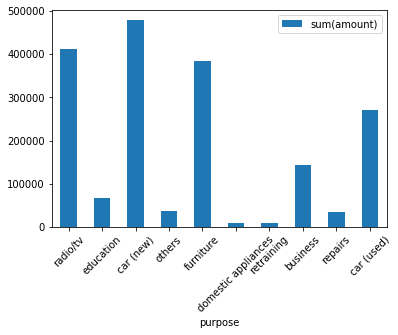

In [33]:
%matplotlib inline
filtro1.groupBy('purpose').agg(F.sum('amount')).toPandas().plot.bar(x='purpose', rot=45)

Ahora, para hacer la comparacion de las consultas anteriores con las mismas ejecutadas en código DQL se siguen los siguientes pasos

In [35]:
#Crear una vista de los datos creditos (Es algo similar a crear una copia de creditos)
creditos.createOrReplaceTempView('VistaCreditos')

In [40]:
#Hacer un select a algunas columnas del dataframe.
spark.sql("""
SELECT credit_history, purpose, amount FROM VistaCreditos
""").show(10)

+--------------+----------+------+
|credit_history|   purpose|amount|
+--------------+----------+------+
|      critical|  radio/tv|  1169|
|        repaid|  radio/tv|  5951|
|      critical| education|  2096|
|        repaid| furniture|  7882|
|       delayed| car (new)|  4870|
|        repaid| education|  9055|
|        repaid| furniture|  2835|
|        repaid|car (used)|  6948|
|        repaid|  radio/tv|  3059|
|      critical| car (new)|  5234|
+--------------+----------+------+
only showing top 10 rows



In [41]:
#Agrupamientos
spark.sql("""
SELECT purpose, sum(amount) as total FROM VistaCreditos group by purpose
""").show(10)

+-------------------+------+
|            purpose| total|
+-------------------+------+
|           radio/tv|696543|
|          education|159020|
|          car (new)|716748|
|             others| 98512|
|          furniture|555125|
|domestic appliances| 17976|
|         retraining| 10853|
|           business|403330|
|            repairs| 60018|
|         car (used)|553133|
+-------------------+------+



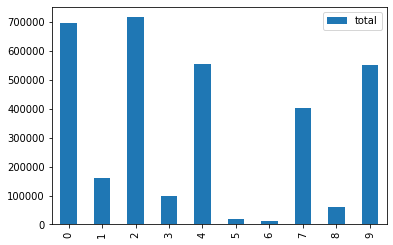

In [43]:
#Graficar los resultados
spark.sql("""
SELECT purpose, sum(amount) as total FROM VistaCreditos group by purpose
""").toPandas().plot.bar()

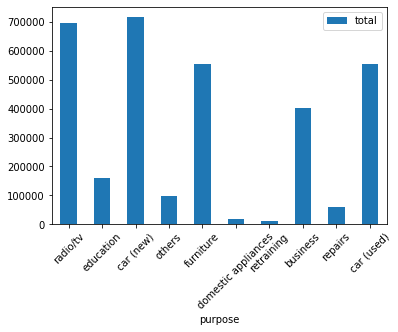

In [44]:
#Graficar los resultados
spark.sql("""
SELECT purpose, sum(amount) as total FROM VistaCreditos group by purpose
""").toPandas().plot.bar(x='purpose', rot=45)

In [45]:
#Agrupamientos
spark.sql("""
SELECT credit_history, count(*) as total FROM VistaCreditos group by credit_history
""").show(10)

+--------------------+-----+
|      credit_history|total|
+--------------------+-----+
|            critical|  293|
|fully repaid this...|   49|
|             delayed|   88|
|              repaid|  530|
|        fully repaid|   40|
+--------------------+-----+



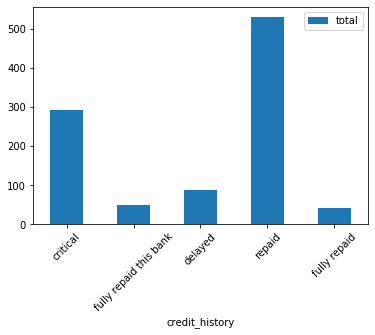

In [47]:
#Graficar los resultados
spark.sql("""
SELECT credit_history, count(*) as total FROM VistaCreditos group by credit_history
""").toPandas().plot.bar(x='credit_history', rot=45)

Para usar parquet en spark se hace de la siguietne manera